In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

# =================================================================================
# CONFIGURACIÓN (AJUSTA ESTOS PARÁMETROS SEGÚN TU CASO)
# =================================================================================
OUTPUT_DIR = "../SPOD_results/Media"          # Directorio de resultados
RESULTS_DIR = "../SPOD_results"
nx = 512                                # Puntos en dirección x (ajustar)
ny = 1200                               # Puntos en dirección y (ajustar)
variables = ["density", "x_velocity", "y_velocity", "Temp"]  # Variables
# =================================================================================

# Cargar autovalores
eigenvalues = np.load(os.path.join(RESULTS_DIR, "spod_eigenvalues.npy"))
N_FFT, N_modes = eigenvalues.shape

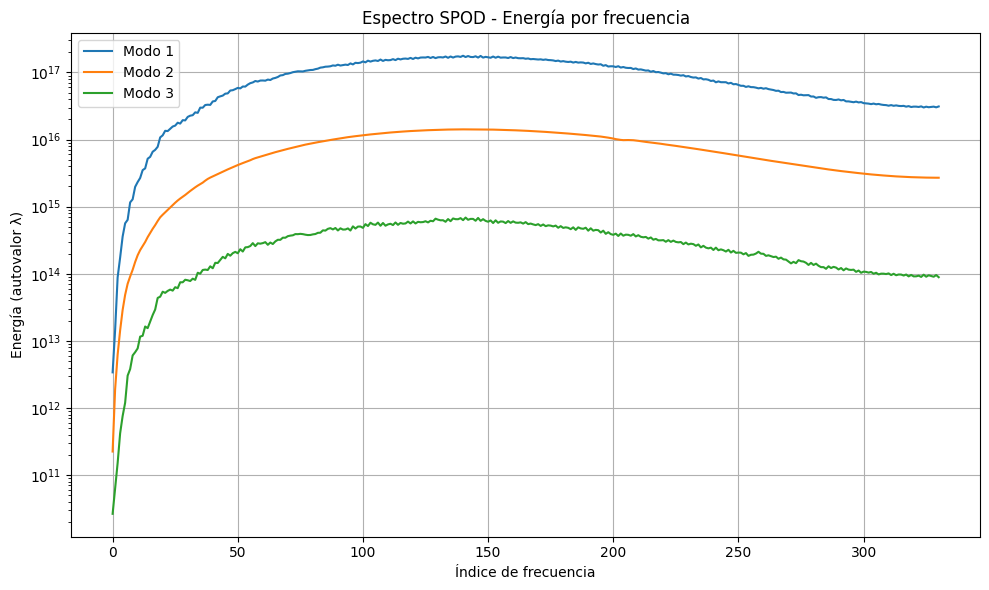

In [4]:
# 1. Visualización del espectro de energía (autovalores)
plt.figure(figsize=(10, 6))
for mode in range(min(5, N_modes)):  # Primeros 5 modos
    plt.semilogy(eigenvalues[:, mode], label=f'Modo {mode+1}')

plt.title("Espectro SPOD - Energía por frecuencia")
plt.xlabel("Índice de frecuencia")
plt.ylabel("Energía (autovalor λ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "spod_energy_spectrum.png"))
plt.show()

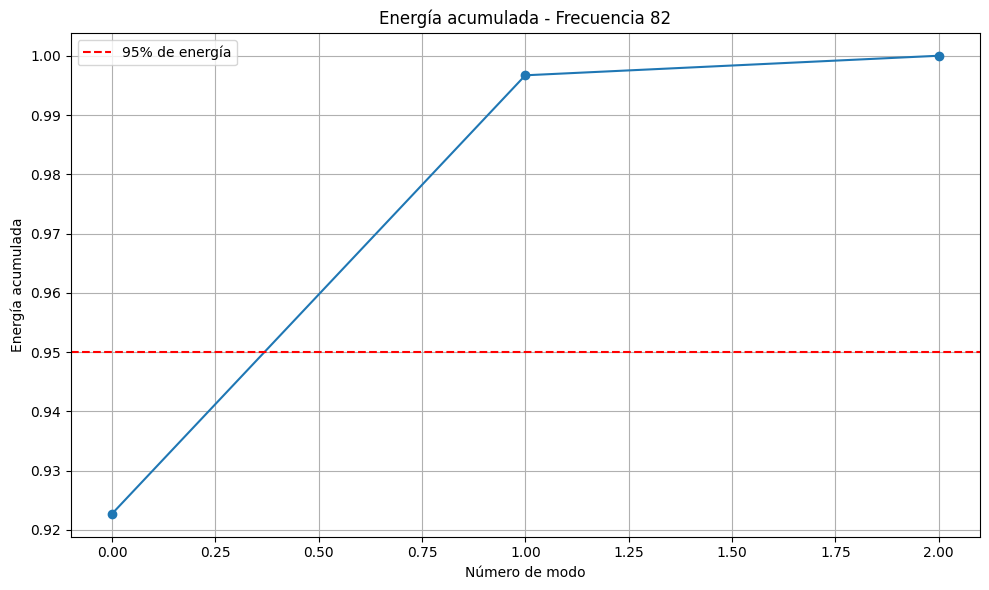

In [5]:
# 2. Gráfico de energía acumulada por modo (a frecuencia fija)
freq_idx = N_FFT // 4  # Frecuencia de ejemplo (25% del rango)
total_energy = np.sum(eigenvalues[freq_idx])
cumulative_energy = np.cumsum(eigenvalues[freq_idx]) / total_energy

plt.figure(figsize=(10, 6))
plt.plot(cumulative_energy, 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de energía')
plt.title(f"Energía acumulada - Frecuencia {freq_idx}")
plt.xlabel("Número de modo")
plt.ylabel("Energía acumulada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"cumulative_energy_freq{freq_idx}.png"))
plt.show()

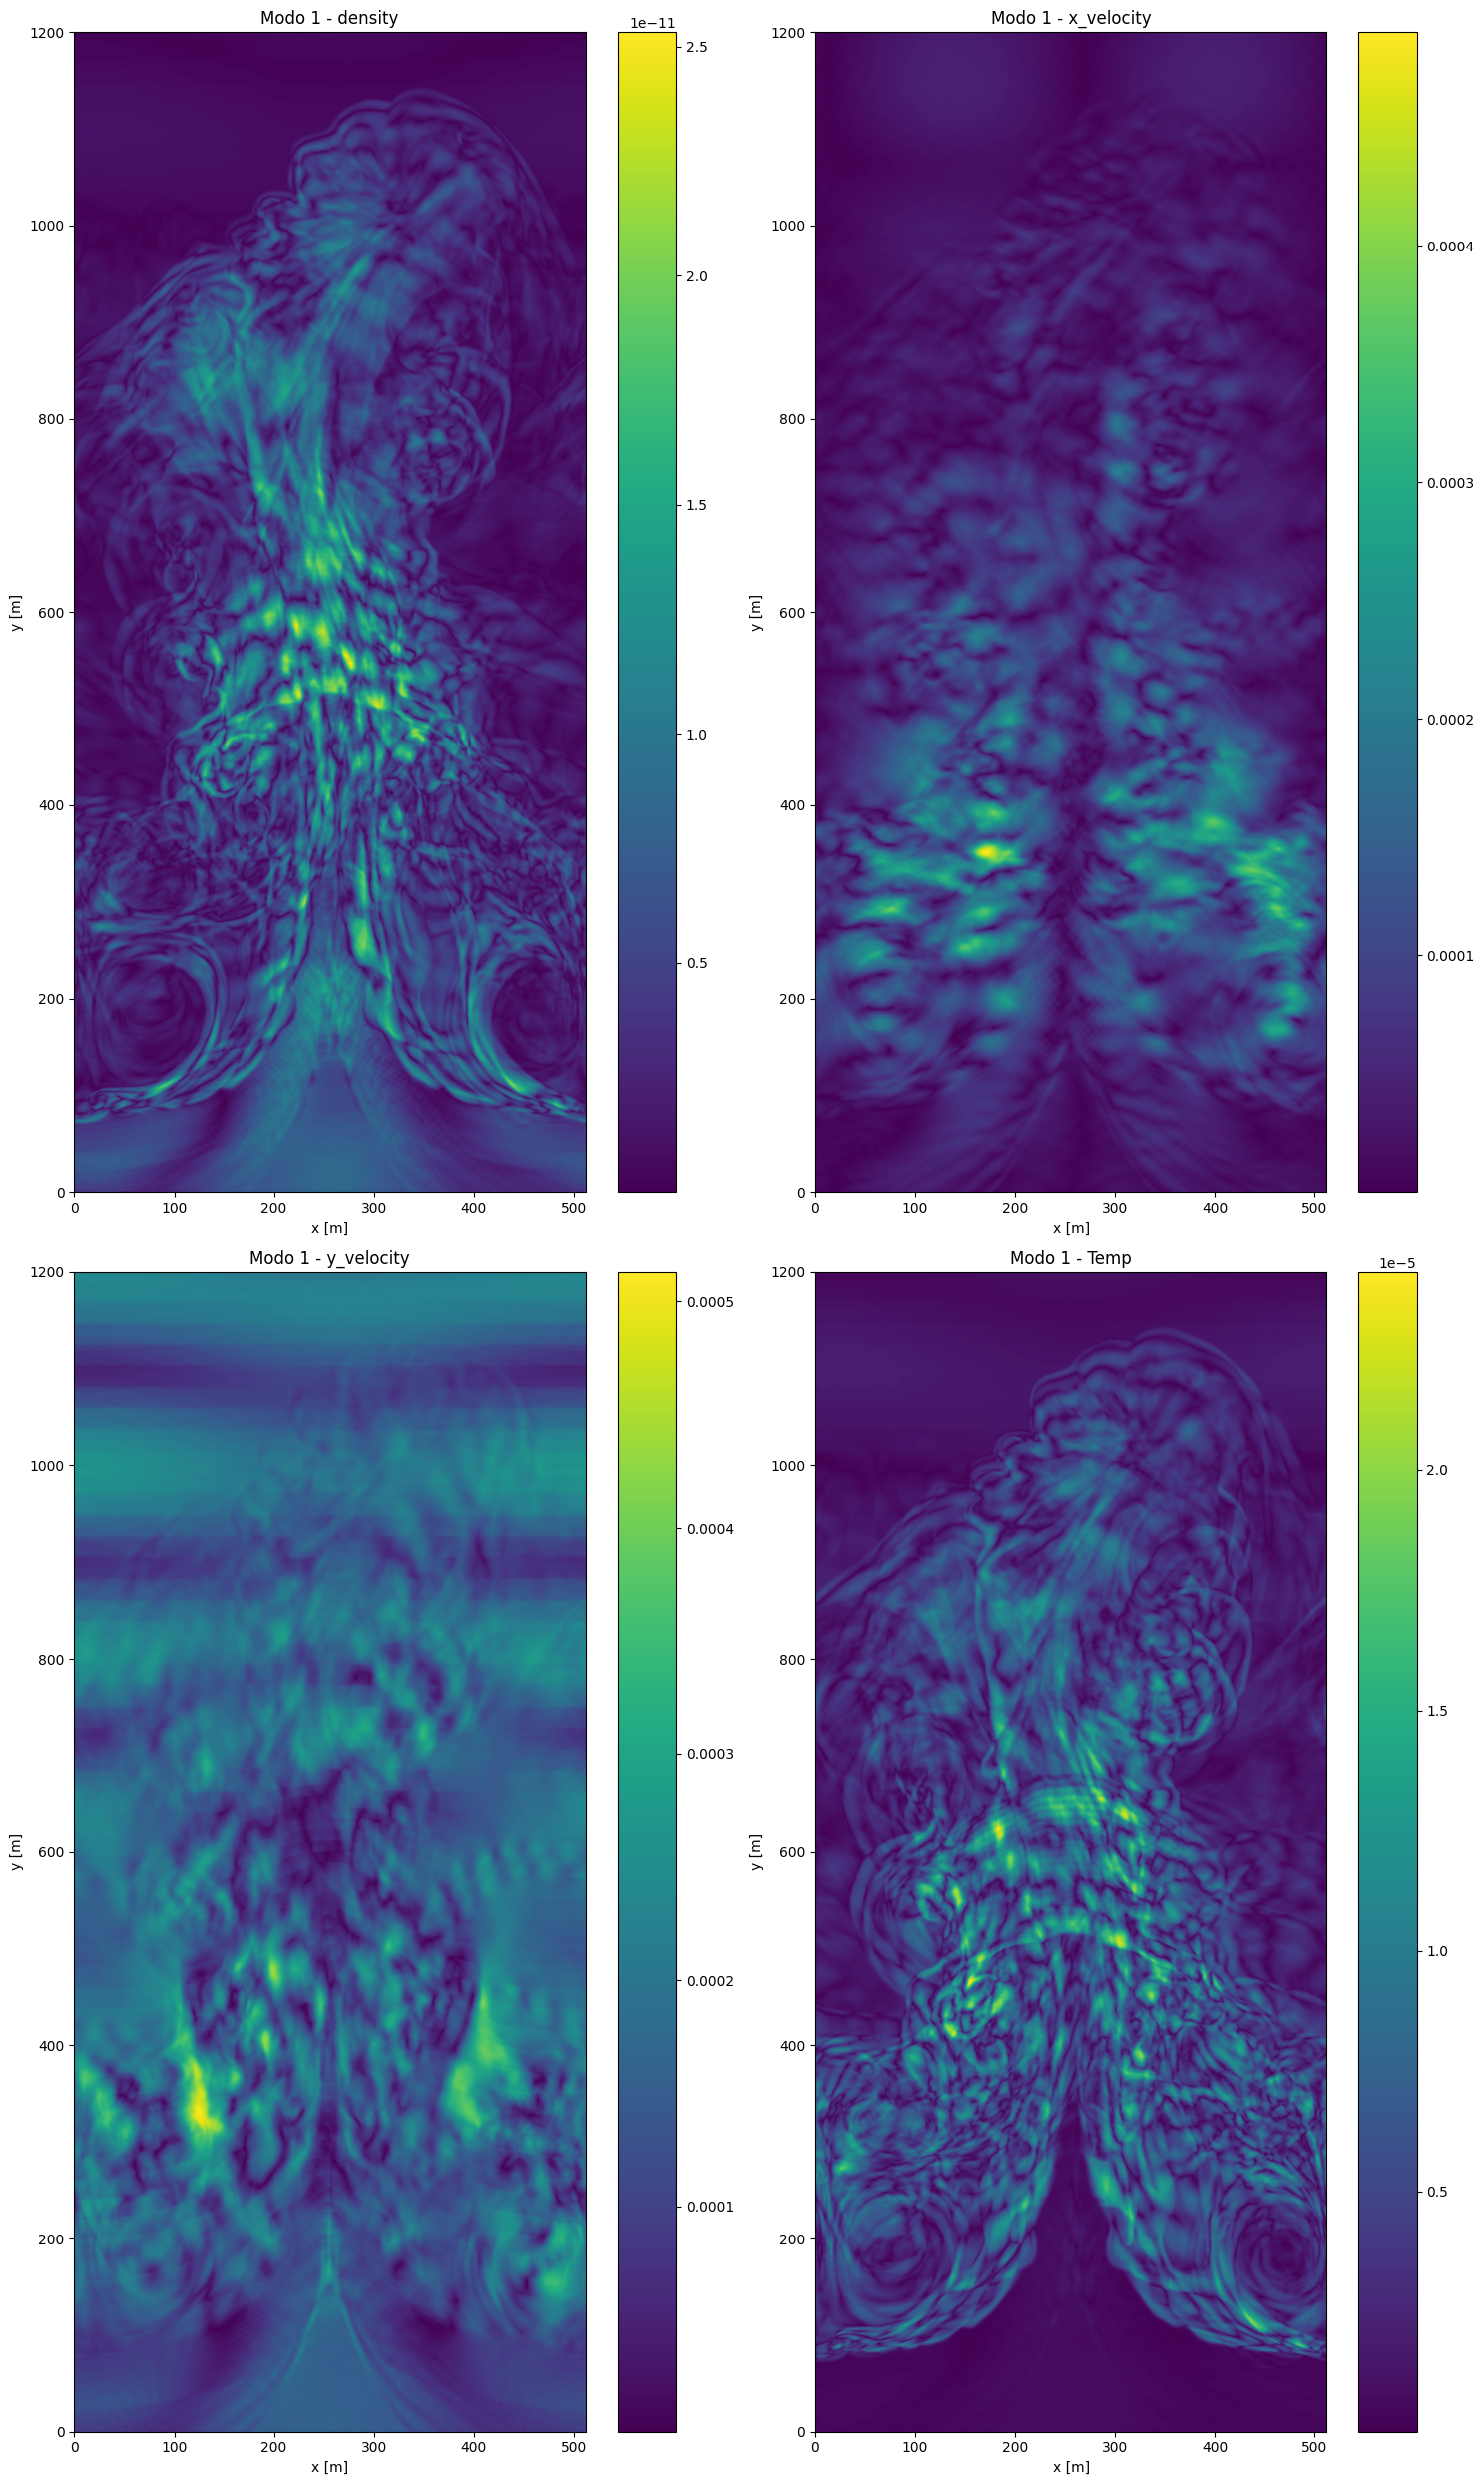

In [6]:
# 3. Visualización de estructuras modales
freq_idx = 30    # Frecuencia a visualizar (ajustar según interés)
mode_idx = 0    # Modo principal (más energético)

# Cargar modo desde HDF5
with h5py.File(os.path.join(RESULTS_DIR, "spod_results.h5"), 'r') as hf:
    mode_data = hf['modes'][freq_idx, :, mode_idx]  # Vector complejo (M,)

# Separar variables y remodelar a 2D
components = []
start = 0
for _ in variables:
    end = start + nx * ny
    component = mode_data[start:end].reshape(nx, ny)
    components.append(component)
    start = end

# Asumiendo que tu dominio físico tiene dimensiones Lx y Ly
Lx = 512.0  # Longitud en dirección x (ajusta según tu caso)
Ly = 1200.0  # Longitud en dirección y

# Crear malla de coordenadas físicas
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='ij')  # 'ij' para que coincida con el orden de los datos

fig, axs = plt.subplots(2, 2, figsize=(15, 25))

for i, (var, component) in enumerate(zip(variables, components)):
    ax = axs[i//2, i%2]
    im = ax.imshow(np.abs(component).T,  # Transponer para orientación correcta
                 extent=[0, Lx, 0, Ly],
                 origin='lower',
                 aspect='auto',  # Auto-ajuste basado en extent
                 cmap='viridis',
                 interpolation='bilinear')
    
    ax.set_title(f"Modo {mode_idx+1} - {var}")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"spod_mode{mode_idx}.png"))
plt.show()

In [9]:
with h5py.File(os.path.join(RESULTS_DIR, "spod_results.h5"), 'r') as hf:
    print("Contenido del archivo HDF5:", list(hf.keys()))

Contenido del archivo HDF5: ['modes']
